In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import _init_paths
import os
os.environ['CUDA_VISIBLE_DEVICES']='0'
import sys
import numpy as np
import argparse
import pprint
import pdb
import time
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import pickle
from roi_data_layer.roidb import combined_roidb
from roi_data_layer.roibatchLoader import roibatchLoader
from model.utils.config import cfg, cfg_from_file, cfg_from_list, get_output_dir
from model.rpn.bbox_transform import clip_boxes
from model.nms.nms_wrapper import nms
# from model.utils.cython_nms import nms
from model.rpn.bbox_transform import bbox_transform_inv
from model.utils.net_utils import save_net, load_net, vis_detections
from model.faster_rcnn.vgg16 import vgg16
from model.faster_rcnn.resnet import resnet
from model.utils.blob import im_list_to_blob
import nn as mynn
import torch.nn.functional as F

import pdb

try:
    xrange          # Python 2
except NameError:
    xrange = range  # Python 3
CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')
from matplotlib import pyplot as plt

In [2]:
def _get_image_blob(im):
    """Converts an image into a network input.
    Arguments:
        im (ndarray): a color image in BGR order
    Returns:
        blob (ndarray): a data blob holding an image pyramid
        im_scale_factors (list): list of image scales (relative to im) used
            in the image pyramid
        im_shapes: the list of image shapes
    """
    im_orig = im.astype(np.float32, copy=True)
    im_orig -= cfg.PIXEL_MEANS
    im_shape = im_orig.shape
    im_size_max = np.max(im_shape[0:2])
    processed_ims = []
    im_scale_factors = []

    for target_size in cfg.TEST.SCALES:
        im_scale = float(target_size) / float(im_size_max)
        im = cv2.resize(im_orig, None, None, fx=im_scale, fy=im_scale,
                        interpolation=cv2.INTER_LINEAR)
        im_scale_factors.append(im_scale)
        processed_ims.append(im_list_to_blob([im]))

    blob = processed_ims
    return blob, np.array(im_scale_factors)

def _get_rois_blob(im_rois, im_scale_factors):
    """Converts RoIs into network inputs.
    Arguments:
        im_rois (ndarray): R x 4 matrix of RoIs in original image coordinates
        im_scale_factors (list): scale factors as returned by _get_image_blob
    Returns:
        blob (ndarray): R x 5 matrix of RoIs in the image pyramid
    """
    rois_blob_real = []

    for i in xrange(len(im_scale_factors)):
        rois, levels = _project_im_rois(im_rois, np.array([im_scale_factors[i]]))
        rois_blob = np.hstack((levels, rois))
        rois_blob_real.append(rois_blob.astype(np.float32, copy=False))

    return rois_blob_real

def _project_im_rois(im_rois, scales):
    """Project image RoIs into the image pyramid built by _get_image_blob.
    Arguments:
        im_rois (ndarray): R x 4 matrix of RoIs in original image coordinates
        scales (list): scale factors as returned by _get_image_blob
    Returns:
        rois (ndarray): R x 4 matrix of projected RoI coordinates
        levels (list): image pyramid levels used by each projected RoI
    """
    im_rois = im_rois.astype(np.float, copy=False)

    if len(scales) > 1:
        widths = im_rois[:, 2] - im_rois[:, 0] + 1
        heights = im_rois[:, 3] - im_rois[:, 1] + 1
        areas = widths * heights
        scaled_areas = areas[:, np.newaxis] * (scales[np.newaxis, :] ** 2)
        diff_areas = np.abs(scaled_areas - 224 * 224)
        levels = diff_areas.argmin(axis=1)[:, np.newaxis]
    else:
        levels = np.zeros((im_rois.shape[0], 1), dtype=np.int)

    rois = im_rois * scales[levels]

    return rois, levels

def _get_blobs(im, rois):
    """Convert an image and RoIs within that image into network inputs."""
    blobs = {'data' : None, 'rois' : None}
    blobs['data'], im_scale_factors = _get_image_blob(im)
    blobs['rois'] = _get_rois_blob(rois, im_scale_factors)
    
    return blobs, im_scale_factors

def im_detect(data, rois, labels, model):
    inputs = {'data': [Variable(torch.from_numpy(data))],
            'rois': [Variable(torch.from_numpy(rois))],
            'labels': [Variable(torch.from_numpy(labels))],
            'seg_map': [Variable(torch.from_numpy(np.zeros((1,1))))]}
    data_tensor = Variable(torch.from_numpy(data)).cuda()
    rois_tensor = Variable(torch.from_numpy(rois)).cuda()
    labels_tensor = Variable(torch.from_numpy(labels)).cuda
    seg_map = Variable(torch.from_numpy(np.zeros((1,1)))).cuda()
    pcl_prob0, pcl_prob1, pcl_prob2 = model(data_tensor, rois_tensor, labels_tensor, seg_map)

    scores = pcl_prob0 + pcl_prob1 + pcl_prob2

    scores = scores.data.cpu().numpy()

    return scores[:, 1:].copy() / 3.

def _get_seg_map(seg_map_path, im_scale_factors):
    seg_map_path = seg_map_path.replace('JPEGImages','SEG_MAP')
    seg_map_path = seg_map_path.replace('jpg','png')

    seg_map = cv2.imread(seg_map_path)
    seg_map = seg_map[:,:,0]
    if(roidb[0]['flipped']):
        seg_map = np.flip(seg_map, axis=1)

    seg_maps = []
    for im_scale in im_scale_factors:
        seg_map = cv2.resize(seg_map, None, None, fx=im_scale, fy=im_scale,
                             interpolation=cv2.INTER_NEAREST)
        seg_maps.append(seg_map.astype('float32'))
    return seg_maps
def demo(net, image_name, roidb):
    """Detect object classes in an image using pre-computed object proposals."""

    # Load the demo image
    #im_file = os.path.join(cfg.DATA_DIR, 'demo', image_name)
    im = cv2.imread(image_name)

    # Detect all object classes and regress object bounds
    #timer = Timer()
    #timer.tic()
    boxes=roidb['boxes']
    blobs, _ = _get_blobs(im, boxes)
    for j in range(len(blobs['data'])):
        scores_tmp = im_detect(blobs['data'][j], blobs['rois'][j], roidb['labels'], net)
        
        if j==0:
            scores = scores_tmp.copy()
        else:
            scores += scores_tmp
    scores /= len(blobs['data'])    
        
    #timer.toc()

    # Visualize detections for each class
    CONF_THRESH = 0.7
    NMS_THRESH = 0.3
    for cls_ind, cls in enumerate(CLASSES):
        #cls_ind += 1 # because we skipped background
        #cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
        cls_boxes = boxes
        cls_scores = scores[:, cls_ind]
        dets = np.hstack((cls_boxes,
                          cls_scores[:, np.newaxis])).astype(np.float32)
        keep = nms(dets, NMS_THRESH)
        dets = dets[keep.data.cpu().numpy(), :]
        vis_detections_rcnn(im, cls, dets, thresh=CONF_THRESH)
def vis_detections_rcnn(im, class_name, dets, thresh=0.5):
    """Draw detected bounding boxes."""
    #print(dets)
    #print('thresh ',thresh)
    #print(dets[:,-1].max())
    inds = np.where(dets[:, -1] >= thresh)[0]
    #print(len(inds))
    if len(inds) == 0:
        #print('hahaha')
        return

    im = im[:, :, (2, 1, 0)]
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.imshow(im, aspect='equal')
    for i in inds:
        bbox = dets[i, :4]
        score = dets[i, -1]
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                          bbox[2] - bbox[0],
                          bbox[3] - bbox[1], fill=False,
                          edgecolor='red', linewidth=3.5)
            )
        ax.text(bbox[0], bbox[1] - 2,
                '{:s} {:.3f}'.format(class_name, score),
                bbox=dict(facecolor='blue', alpha=0.5),
                fontsize=14, color='white')

    ax.set_title(('{} detections with '
                  'p({} | box) >= {:.1f}').format(class_name, class_name,
                                                  thresh),
                  fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
def visualize_gt(image, gt_boxes, cls):
    img = image.copy()
    img = img[:,:,[2,1,0]]
    fig,ax = plt.subplots(figsize=(12,12))
    ax.imshow(img, aspect='equal')
    cntr = -1

    for i in range(gt_boxes.shape[0]):
        bbox = gt_boxes[i, :4]
        
        ax.add_patch(
            plt.Rectangle((bbox[0], bbox[1]),
                              bbox[2] - bbox[0],
                              bbox[3] - bbox[1], fill=False,
                              edgecolor='blue', linewidth=3.5
            )
        )
        ax.text(bbox[0], bbox[1] - 2,
                    '{:s} '.format(CLASSES[int(cls)]),
                    bbox=dict(facecolor='blue', alpha=0.5),
                    fontsize=14, color='white')
        cntr += 1
    ax.set_title('several samples')
    plt.axis('off')
    plt.tight_layout()
    

In [3]:
def im_detect_cls(data, rois, labels, net):
    inputs = {'data': [Variable(torch.from_numpy(data))],
            'rois': [Variable(torch.from_numpy(rois))],
            'labels': [Variable(torch.from_numpy(labels))],
            'seg_map': [Variable(torch.from_numpy(np.zeros((1,1))))]}
    data_tensor = Variable(torch.from_numpy(data)).cuda()
    rois_tensor = Variable(torch.from_numpy(rois)).cuda()
    labels_tensor = Variable(torch.from_numpy(labels)).cuda()
    seg_map = Variable(torch.from_numpy(np.zeros((1, 1)))).cuda()
    base_feat = fasterRCNN.RCNN_base(data_tensor)
    pooled_feat = fasterRCNN.RCNN_roi_pool(base_feat, rois_tensor.view(-1,5).type(base_feat.dtype))
    fc_feat = fasterRCNN._head_to_tail(pooled_feat)
    cls0_score0 = fasterRCNN.RCNN_cls0_score0(fc_feat)
    cls0_score1 = fasterRCNN.RCNN_cls0_score1(fc_feat)
    cls0_prob = F.softmax(cls0_score0,1)*F.softmax(cls0_score1,0)
    
    cls1_score0 = fasterRCNN.RCNN_cls1_score0(fc_feat)
    cls1_score1 = fasterRCNN.RCNN_cls1_score1(fc_feat)
    cls1_prob = F.softmax(cls1_score0,1)*F.softmax(cls1_score1,0)
    
    return cls0_prob.data.cpu().numpy(), cls1_prob.data.cpu().numpy()

In [5]:
dataset='pascal_voc_2007'
imdb_val='voc_2007_test'
checksession=1
checkepoch=15
checkpoint=5010
load_dir='../output/7-14'
net='vgg16'

In [6]:
cfg.TRAIN.USE_FLIPPED = False
imdb, roidb, ratio_list, ratio_index = combined_roidb(imdb_val, False)
imdb.competition_mode(on=True)

Loaded dataset `voc_2007_test` for training
Preparing training data...
voc_2007_test ss roidb loaded from /media/vasgaoweithu/0BCB122F0BCB122F/vasgaowei/demo/CMIDN_MCD/data/cache/voc_2007_test_selective_search_roidb.pkl
done


In [7]:
len(roidb)

4952

In [8]:
roidb[0]['labels']

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]],
      dtype=int32)

In [9]:
cfg_file='../cfgs/vgg16.yml'
cfg_from_file(cfg_file)

In [10]:
fasterRCNN = vgg16(imdb.classes, pretrained=False)

In [11]:
input_dir = os.path.join(load_dir, net, dataset)

In [12]:
load_name = os.path.join(input_dir, 'faster_rcnn_{}_{}_{}.pth'.format(checksession, checkepoch, checkpoint))

In [13]:
fasterRCNN.create_architecture()

In [14]:
check_point_load = torch.load(load_name)

In [15]:
tmp_state_dict = check_point_load['model']

In [16]:
correct_state_dict = {k:tmp_state_dict['module.'+k] for k in fasterRCNN.state_dict()}

In [17]:
fasterRCNN.load_state_dict(correct_state_dict)

In [18]:
cfg.POOLING_MODE=check_point_load['pooling_mode']

In [19]:
torch.cuda.device_count()

1

In [20]:
cfg.CUDA=True
fasterRCNN.cuda()

vgg16(
  (RCNN_roi_pool): _RoIPooling()
  (RCNN_roi_align): RoIAlignAvg()
  (RCNN_roi_crop): _RoICrop()
  (pcl_losses0): _PCL_Losses()
  (pcl_losses1): _PCL_Losses()
  (pcl_losses2): _PCL_Losses()
  (RCNN_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): 

In [20]:
fasterRCNN = mynn.DataParallel(fasterRCNN,minibatch=True)

In [21]:
fasterRCNN.eval()

vgg16(
  (RCNN_roi_pool): _RoIPooling()
  (RCNN_roi_align): RoIAlignAvg()
  (RCNN_roi_crop): _RoICrop()
  (pcl_losses0): _PCL_Losses()
  (pcl_losses1): _PCL_Losses()
  (pcl_losses2): _PCL_Losses()
  (RCNN_base): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): 

aeroplane 1.0365742e-09
bicycle 1.1641875e-07
bird 1.379391
boat 6.472277e-08
bottle 5.2355702e-08
bus 1.0305013e-08
car 6.489588e-08
cat 9.388247e-09
chair 2.2538478e-09
cow 4.0973188e-08
diningtable 2.632518e-08
dog 5.7551963e-09
horse 4.0688573e-09
motorbike 6.406936e-08
person 6.4649095e-05
pottedplant 1.0633684e-05
sheep 7.628687e-08
sofa 8.534611e-10
train 8.970588e-08
tvmonitor 1.656762e-08


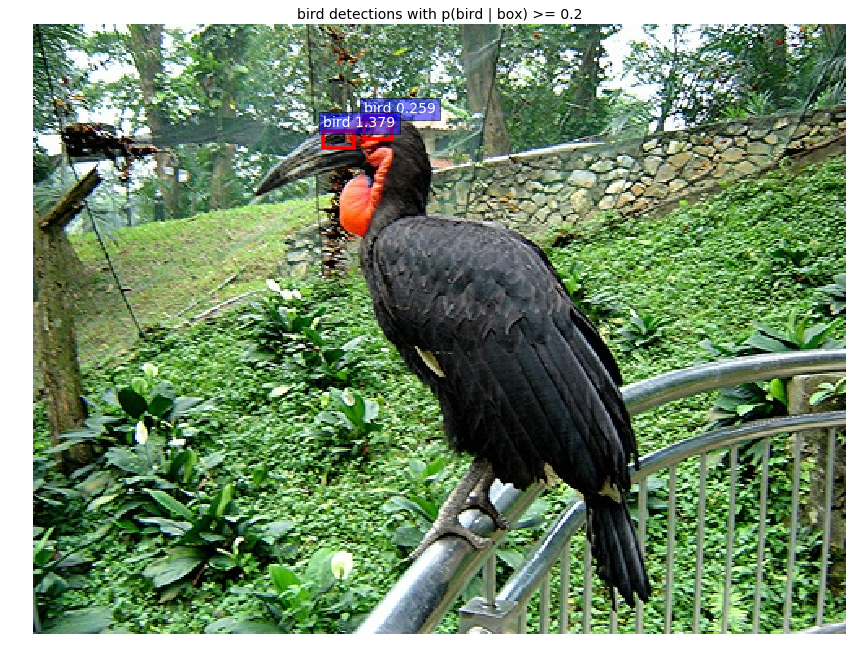

In [56]:
im_path = imdb.image_path_at(28)
im=cv2.imread(im_path)
im_roidb = roidb[28]
boxes=im_roidb['boxes']
blobs, _ = _get_blobs(im, boxes)
for j in range(len(blobs['data'])):
    score_tmp_1, score_tmp_2 = im_detect_cls(blobs['data'][j], blobs['rois'][j], im_roidb['labels'], fasterRCNN)
    if  j==0:
        scores_1 = score_tmp_1.copy()
        scores_2 = score_tmp_2.copy()
    else:
        scores_1 += score_tmp_1
        scores_2 += score_tmp_2

#scores_1 /= len(blobs['data'])
#scores_2 /= len(blobs['data'])
CONF_THRESH = 0.2
NMS_THRESH = 0.3
for cls_ind, cls in enumerate(CLASSES):
    #cls_ind += 1 # because we skipped background
    #cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_boxes = boxes
    cls_scores = scores_1[:, cls_ind]
    print(cls,cls_scores.max())
    dets = np.hstack((cls_boxes,
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep.data.cpu().numpy(), :]
    vis_detections_rcnn(im, cls, dets, thresh=CONF_THRESH)

In [57]:
scores_1.max()

1.379391

In [58]:
scores_2.max()

1.7138288

In [59]:
scores_1.argmax()

21222

In [60]:
gt_1 = int(scores_1.argmax()/20)
cls_1 = int(scores_1.argmax()%20)

In [61]:
scores_2.argmax()

21222

In [62]:
gt_2 = int(scores_2.argmax()/20)

In [63]:
scores_2.argmax()

21222

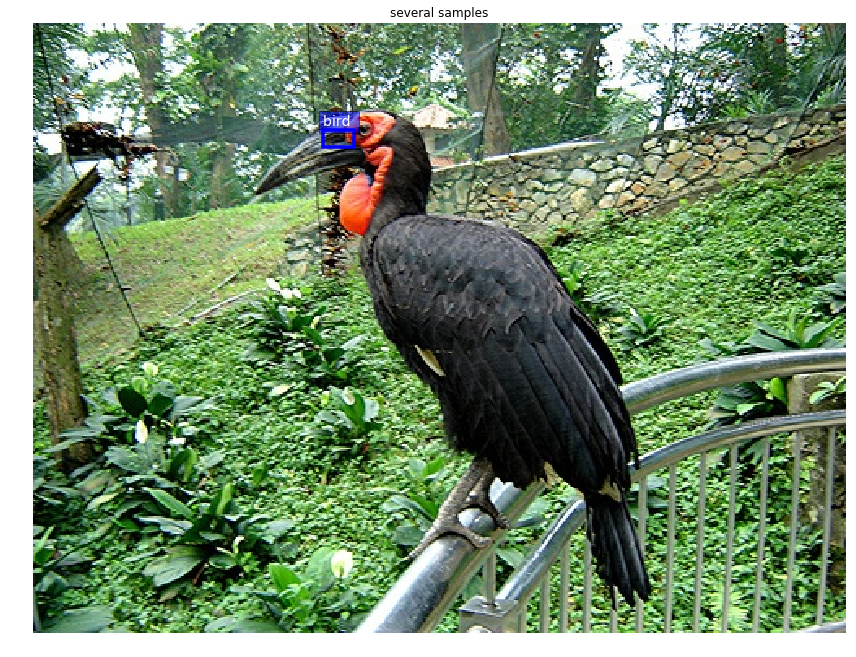

In [64]:
visualize_gt(im, gt_boxes=boxes[gt_1].reshape(1,-1), cls=cls_1)

In [65]:
gt_1

1061

In [66]:
scores_1[gt_1]

array([2.4743328e-12, 1.0526742e-14, 1.3793910e+00, 2.2963868e-13,
       5.2571391e-13, 3.4412916e-14, 1.9461493e-13, 1.5235983e-14,
       1.4579516e-14, 5.7106663e-14, 2.1156740e-13, 8.5884208e-14,
       3.7523560e-15, 1.2698649e-12, 1.3674627e-12, 1.2101392e-13,
       1.7918337e-14, 3.5616143e-15, 4.3143637e-14, 5.0537567e-14],
      dtype=float32)

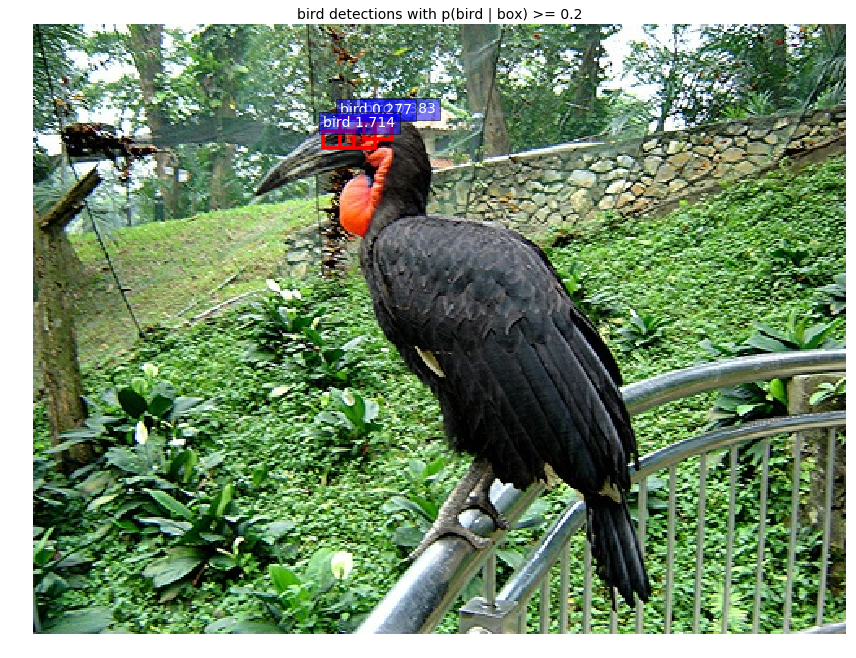

In [67]:
for cls_ind, cls in enumerate(CLASSES):
    #cls_ind += 1 # because we skipped background
    #cls_boxes = boxes[:, 4*cls_ind:4*(cls_ind + 1)]
    cls_boxes = boxes
    cls_scores = scores_2[:, cls_ind]
    dets = np.hstack((cls_boxes,
                      cls_scores[:, np.newaxis])).astype(np.float32)
    keep = nms(dets, NMS_THRESH)
    dets = dets[keep.data.cpu().numpy(), :]
    vis_detections_rcnn(im, cls, dets, thresh=CONF_THRESH)

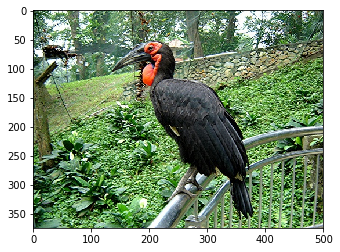

In [68]:
plt.imshow(im[:,:,::-1])

In [33]:
index = np.arange(10, 20)
index = [14,]
    
for i in index:
    im_path = imdb.image_path_at(i)
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
    print('Demo for {}'.format(im_path))
    demo(fasterRCNN, im_path, roidb[i])
        
        
plt.show()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Demo for /media/vasgaoweithu/0BCB122F0BCB122F/vasgaowei/demo/CMIDN_MCD/data/VOCdevkit2007/VOC2007/JPEGImages/000027.jpg


In [49]:
imdb

'voc_2007_test'

In [21]:
fasterRCNN.device_ids

[0]

In [ ]:
fasterRCNN.